# Forest Cover Classification

### **By Vinesh Raghvani**

In this project, I will be using deep learning to forecast forest cover type (the most prevalent form of tree cover) using just cartographic data. The actual forest cover type for a specific 30 × 30 meter cell was identified using US Forest Service (USFS) Region 2 Resource Information System data. The cover types are as follows:

1. Spruce/Fir
1. Lodgepole Pine
1. Ponderosa Pine
1. Cottonwood/Willow
1. Aspen
1. Douglas-fir
1. Krummholz

## Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [34]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

## Defining a function to sort and prepare the data for usage 

In [35]:
def prep_data(raw_df):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data
    
    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

## Defining a Build Model function 

In [36]:
def build_model(num_features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

## Defining a Confusion Matrix and Heatmap function

In [37]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

## Defining a funtion to check the performance of the Model

In [38]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

## Defining a main() function below which will prepare the dataset, builds the model, evaluates the model and gives predictions. Then we will plot the performance metrics.

In [39]:
def main():
    infile = 'cover_data.csv'
    raw_df = pd.read_csv(infile)

    # EDA
    # Uncomment the below two lines to run EDA. Takes > 10 min to run.
    #my_report = sv.analyze(raw_df)
    #my_report.show_html()

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

Summary report of Keras classifier:


c:\Users\dexte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6283 - loss: 0.9844 - val_accuracy: 0.7479 - val_loss: 0.6046
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7521 - loss: 0.5886 - val_accuracy: 0.7656 - val_loss: 0.5534
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7695 - loss: 0.5433 - val_accuracy: 0.7755 - val_loss: 0.5259
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7806 - loss: 0.5176 - val_accuracy: 0.7860 - val_loss: 0.5040
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.4968 - val_accuracy: 0.7907 - val_loss: 0.4891
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7943 - loss: 0.4841 - val_accuracy: 0.7976 - val_loss: 0.4750
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8015 - loss: 0.4708 - val_accuracy: 0.8049 - val_loss: 0.4670
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8070 - loss: 0.4569 - val_accu

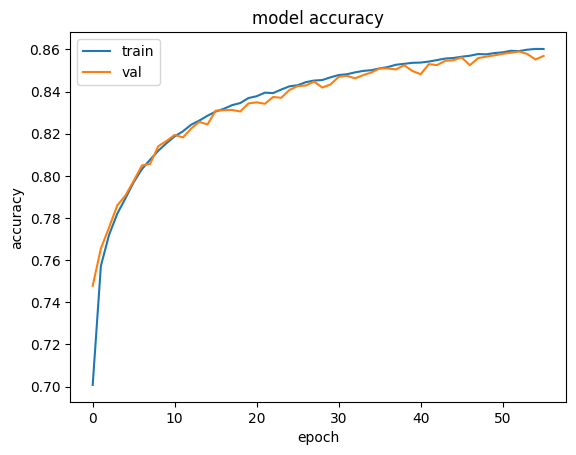

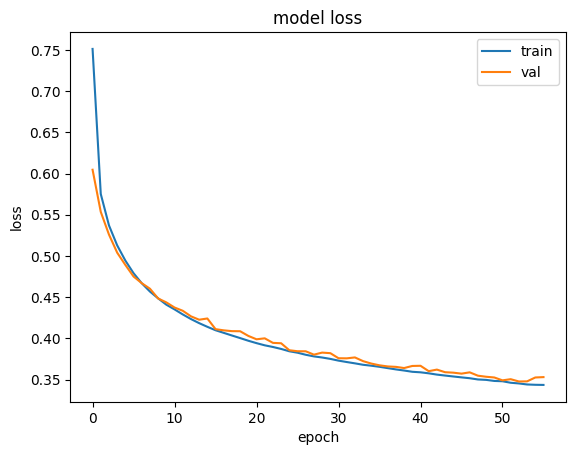

Test loss: 0.35384562611579895
Test accuracy: 0.856957197189331
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.90      0.80      0.85     42368
   Lodgepole Pine       0.85      0.92      0.88     56661
   Ponderosa Pine       0.80      0.90      0.85      7151
Cottonwood/Willow       0.80      0.72      0.76       549
            Aspen       0.71      0.55      0.62      1899
      Douglas-fir       0.76      0.59      0.66      3473
        Krummholz       0.88      0.85      0.87      4102

         accuracy                           0.86    116203
        macro avg       0.81      0.76      0.78    116203
     weighted avg       0.86      0.86      0.86    116203



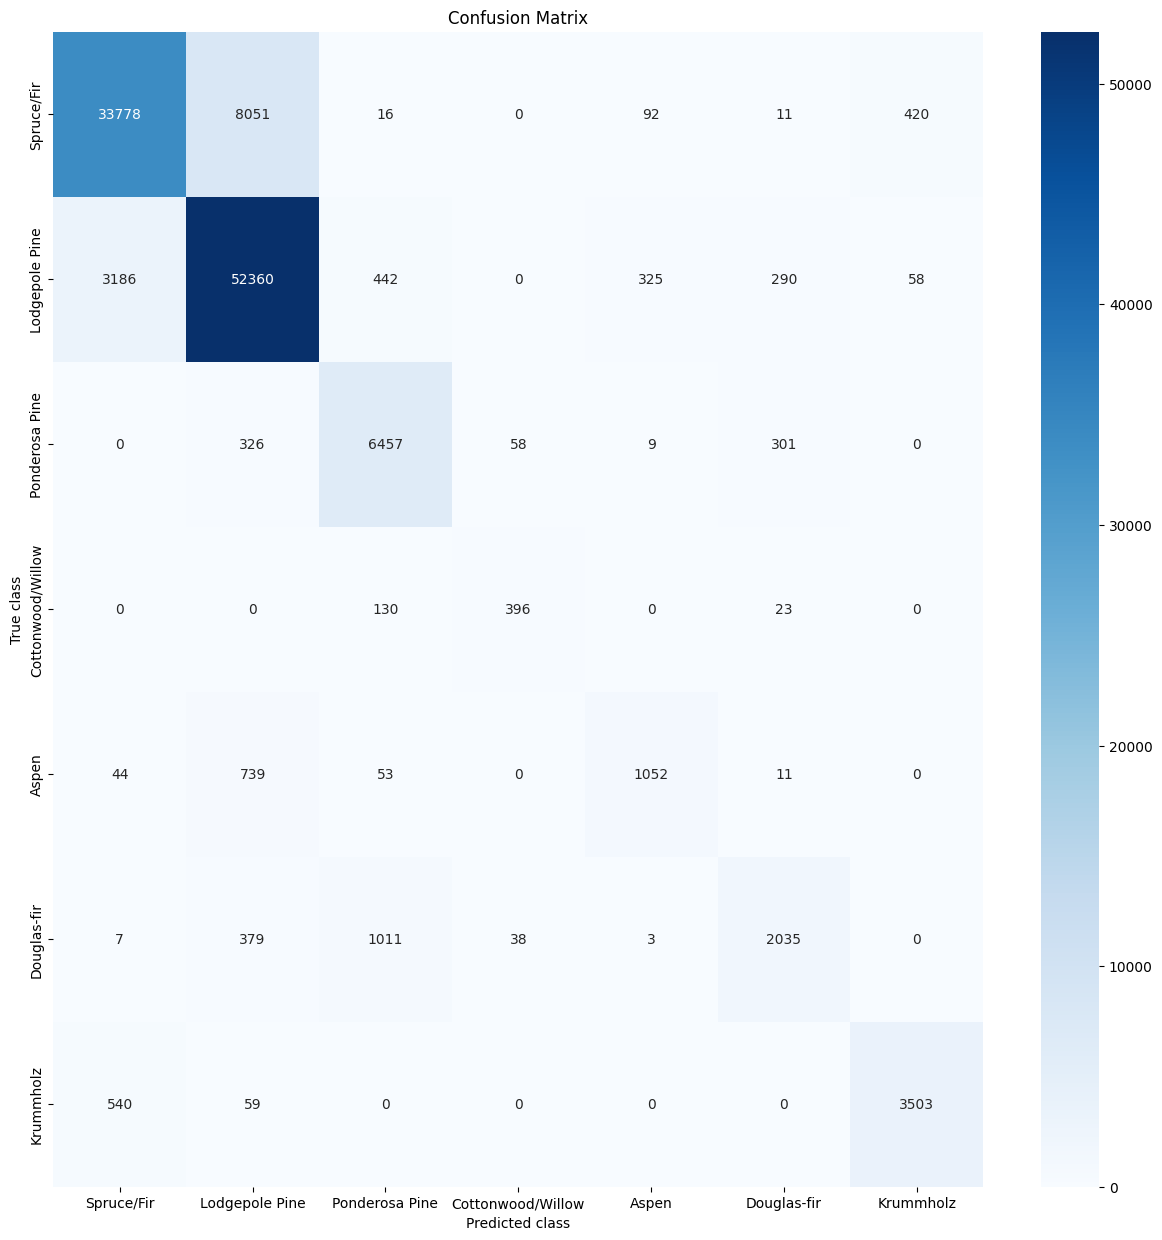

In [40]:
if __name__ == '__main__':
    main()